# Classification of Malicious URL using Deep Learning with Keras
**University of Toronto School of Continuing Studies** \
SCS 3546 Deep Learning


Name: <pre>Arjie Cristobal</pre>
Student Number: <pre>X261973</pre>

# Introduction
Artificial Intelligence (AI) and cybersecurity are two of the most rapidly growing sectors in the technology industry.

The global AI in cybersecurity market was valued at \$19.2 billion  in 2022 , and is projected to reach \$154.8 billion by 2032, growing at a CAGR of 23.6% from 2023 to 2032.1

The future growth of both AI and cybersecurity is promising and will be critical in the future.





# Objective

This study will explore a lightweight approach to identify and classify malicious URL using deep learning via Keras.

# Dataset
**University of New Brunswick** \
Canadian Institute for Cybersecurity

[URL dataset (ISCX-URL2016)](https://www.unb.ca/cic/datasets/url-2016.html)

### Loading and Preparing the dataset

This study reused the [UrlDatasetLoader](https://nbviewer.org/github/quickheaven/scs-3253-machine-learning/blob/977a523a096097b350ec78cfcfc7357142e0fe1e/loader_nb.ipynb) from the Machine Learning (ML) project [Detection and categorization of malicious URLs](https://quickheaven.github.io/scs-3253-machine-learning/) for data cleaning and preparation. It is responsible on handling null and na values, feature selections and anomaly detection.

The prepared dataset is then exported to CSV files and uploaded to Deep Learning Git repository for use in training.


**Types of Malicious URLs**
* Defacement
* Benign
* Phishing
* Malware
* Spam

# Prepare the Environment and Library

**Install Scikeras libraries**

In [ ]:
!pip install scikeras

**Import Required Python libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense
from keras.metrics import Accuracy, F1Score
from keras.models import Sequential
from keras.utils import to_categorical
from keras import backend as K
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier, KerasRegressor


warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# mount the colab
from google.colab import drive
drive.mount('/content/drive')

# For saving and retrieving the trained model
WORKSPACE_PATH = "/content/drive/MyDrive/Colab Notebooks/models/"

Mounted at /content/drive


# Load the dataset



In [ ]:
# Read the dataset from github
url = 'https://raw.githubusercontent.com/quickheaven/scs-3546-deep-learning/master/datasets/'

X_train = pd.read_csv(url + 'X_train.csv', index_col=0)
X_test =pd.read_csv(url + 'X_test.csv', index_col=0)

y_train =pd.read_csv(url + 'y_train.csv', index_col=0)
y_test = pd.read_csv(url + 'y_test.csv', index_col=0)

In [ ]:
# Initialize input dim and output nodes
NUM_INPUT_DIM = X_train.shape[1]
NUM_OUTPUT_NODES = len(y_train['URL_Type_obf_Type'].unique())

#
y_train_dummy = to_categorical(y_train)
y_test_dummy = to_categorical(y_test)

# Training and Tuning Model

The training and tuning of model is divided into three main experiments. Tuning of Deep Network, Tuning the Back Propagation and last is the Overfitting Management.

The first step before proceeding to other experiments is Tuning the Neural Network. These includes determining first the epoch and batch size to use, the number of hidden layers to add, the number of nodes in each layer, choosing the activation function and the weight initializer.

The second part is Tuning the Back Propagation. It involves whether to use Batch normalization or not, finding the right Optimizers and its Learning Rates.

Lastly is the Overfitting Management, I used Regularation and Dropout as part of the experiment.

In [ ]:
def get_base_model_config():
  """
  This function returns the based model configuration for the experiments.

  Parameters
  ----------
  None

  Returns
  ----------
  dict - The dictionary containing the based model configuration.
  """

  early_stopping_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
  callbacks = [early_stopping_callback]

  model_config = {
      # ##################################
      "model_name": None,
      "input_dim": NUM_INPUT_DIM,
      "custom_layers": list(),
      "callbacks": callbacks,
      "validation_split": 0.20,
      "loss": "categorical_crossentropy",
      "output_nodes": NUM_OUTPUT_NODES,
      "output_activation": "softmax",
      "metrics": ['accuracy'],
      # ##################################
      "batch_size": 32,
      "epochs": 200,
      "hidden_activation": "relu",
      "weights_initializer": "random_normal",
      # ##################################
      "normalization": None,
      "optimizer": "adam",
      "learning_rate": 0.001,
      "regularizer": None,
      "dropout_rate": None,
      # ##################################
      "is_save_model": False,
      "workspace_path": WORKSPACE_PATH,
      "verbose": 1
  }
  return model_config


In [ ]:
def get_optimizer(optimizer_name, learning_rate):
  """
  (str. float) -> keras.optimizers

  This method returns the optimizer that will be use in the experiment.

  Parameters
  ----------
  optimizer_name - The name of the optimizer to use in the experiment. values are adagrad, rmsprop, adam and None.
  learning_rate - The rate of learning to use in the optimizer.

  Returns
  ----------
  keras.optimizer - The keras optimizer object.
  """
  optimizer=None
  if optimizer_name == 'adagrad':
      optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
  elif 'rmsprop':
      optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif'adam' :
      optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  else :
      optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

  return optimizer

In [ ]:
def create_and_run_model(model_config, X, y):

  # Build the new model
  model = Sequential(layers=model_config['custom_layers'], name=model_config['model_name'])
  model.summary()

  optimizer = get_optimizer(model_config["optimizer"], model_config["learning_rate"])

  # Compile the model
  model.compile(optimizer=optimizer,
                loss=model_config['loss'],
                metrics=model_config['metrics'])

  # Fit the model
  history = model.fit(X, y,
                      batch_size=model_config['batch_size'],
                      callbacks=model_config['callbacks'],
                      epochs=model_config['epochs'],
                      validation_split=model_config['validation_split'],
                      verbose=model_config["verbose"])

  if True == model_config['is_save_model']:
    model_file = str(model_config['workspace_path']) + str(model_config['model_name']) + '.h5'
    model.save(model_file)

  return history

In [ ]:
def plot_accuracy_measures(accuracy_measures, title):

    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))
    for experiment in accuracy_measures.keys():
        plt.plot(accuracy_measures[experiment],
                 label=experiment,
                    linewidth=3)

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
def plot_learning_curves(history, title):
  # plot curves for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Learning Curves ' + title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.plot(figsize=(8, 5))
  plt.grid(True)
  plt.show()

In [ ]:
model_config = get_base_model_config()

## Tuning Deep Neural Network

### Epoch and Batch size tuning
Figure out the right number of batches and epochs first, and then use that for further experimentation.

**Batch Size:** Experiment for the right size, batch size of 32 found most optimal for most use cases.

**Epoch:** Choose the earliest value when accuracy stabilizers.


Model: "Epoch_and_batch_size_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                832       
                                                                 
 dense_7 (Dense)             (None, 5)                 85        
                                                                 
Total params: 917 (3.58 KB)
Trainable params: 917 (3.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
636/636 [==============================] - 4s 5ms/step - loss: 1.3011 - accuracy: 0.5578 - val_loss: 1.0864 - val_accuracy: 0.6352
Epoch 2/200
636/636 [==============================] - 3s 5ms/step - loss: 1.0083 - accuracy: 0.6543 - val_loss: 0.9273 - val_accuracy: 0.6865
Epoch 3/200
636/636 [==============================] - 3s 5ms/step - loss: 0.8973 - accuracy: 0.6913 - val_loss: 0.8493 - v

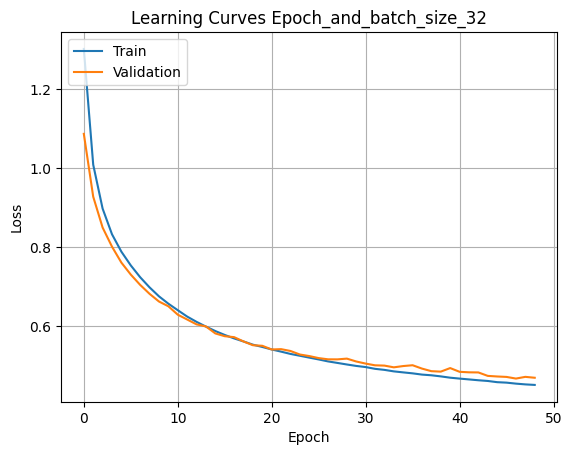

Model: "Epoch_and_batch_size_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                832       
                                                                 
 dense_9 (Dense)             (None, 5)                 85        
                                                                 
Total params: 917 (3.58 KB)
Trainable params: 917 (3.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
318/318 [==============================] - 2s 5ms/step - loss: 1.4376 - accuracy: 0.4816 - val_loss: 1.2671 - val_accuracy: 0.6103
Epoch 2/200
318/318 [==============================] - 2s 5ms/step - loss: 1.1368 - accuracy: 0.6318 - val_loss: 1.0315 - val_accuracy: 0.6657
Epoch 3/200
318/318 [==============================] - 2s 5ms/step - loss: 0.9771 - accuracy: 0.6662 - val_loss: 0.9236 - v

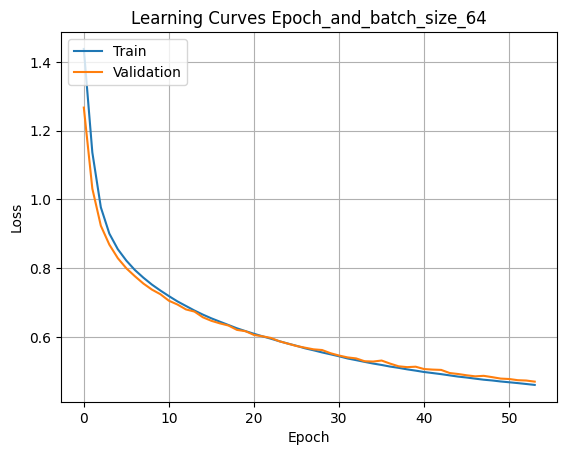

Model: "Epoch_and_batch_size_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                832       
                                                                 
 dense_11 (Dense)            (None, 5)                 85        
                                                                 
Total params: 917 (3.58 KB)
Trainable params: 917 (3.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
159/159 [==============================] - 1s 5ms/step - loss: 1.5190 - accuracy: 0.4015 - val_loss: 1.3869 - val_accuracy: 0.5572
Epoch 2/200
159/159 [==============================] - 1s 4ms/step - loss: 1.2660 - accuracy: 0.5996 - val_loss: 1.1521 - val_accuracy: 0.6333
Epoch 3/200
159/159 [==============================] - 1s 4ms/step - loss: 1.0857 - accuracy: 0.6396 - val_loss: 1.0191 - 

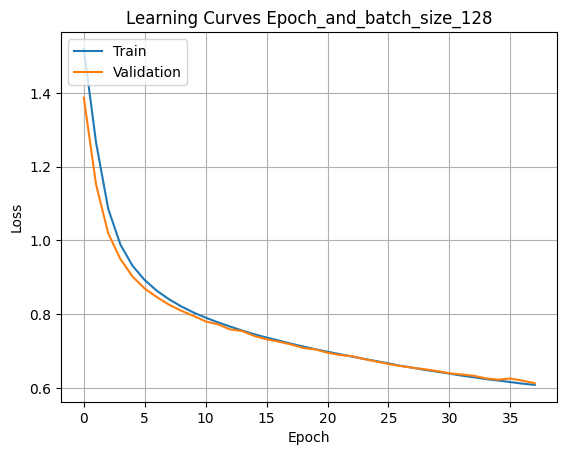

In [ ]:
accuracy_measures = {}
model_config = get_base_model_config()

batch_sizes = [32, 64, 128]

for size in batch_sizes:

  model_config['batch_size'] = size

  custom_layers = [
      layers.Dense(16, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];
  model_name = 'Epoch_and_batch_size_' + str(size)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_batch_epoch = accuracy_measures.copy()

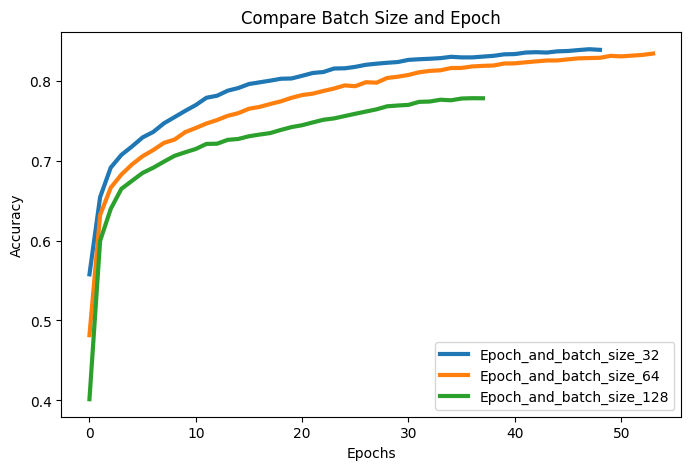

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Batch Size and Epoch")

The model with batch_size_32 offers higher accuracy.

In [ ]:
model_config['batch_size'] = 32
model_config['epochs'] = 50

### Hidden layers tuning

One of the key model architecture hyperparameters is the number of hidden layers. As the number of layers increases, it increases the possibility of learning complex relationships between features and target variables, but it will also increase the cost and time needed for both training and inference. It is also has the risk of overfitting the training set.

A **value of two** has been sufficient for simple problems. It is recommended to increase the number of layers only based on experimentation if the set accuracy levels are not achieved. Otherwise, additional layers will take resources and time without providing any additional value.

Model: "Layers_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 16)                832       
                                                                 
 dense_78 (Dense)            (None, 5)                 85        
                                                                 
Total params: 917 (3.58 KB)
Trainable params: 917 (3.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 5ms/step - loss: 1.3064 - accuracy: 0.5207 - val_loss: 1.0968 - val_accuracy: 0.6236
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 1.0096 - accuracy: 0.6558 - val_loss: 0.9319 - val_accuracy: 0.6847
Epoch 3/50
636/636 [==============================] - 2s 4ms/step - loss: 0.9002 - accuracy: 0.6875 - val_loss: 0.8587 - val_accuracy: 0.697

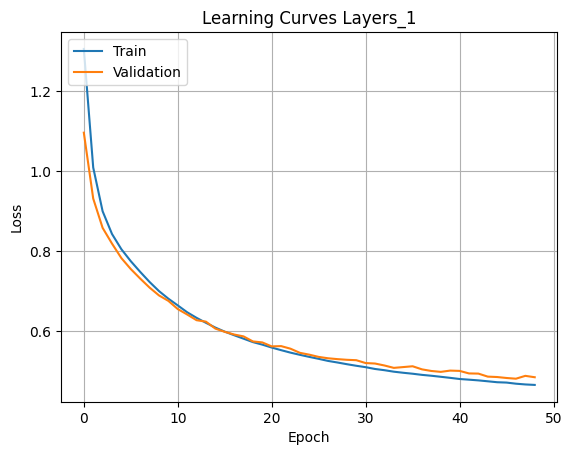

Model: "Layers_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 16)                832       
                                                                 
 dense_80 (Dense)            (None, 16)                272       
                                                                 
 dense_81 (Dense)            (None, 5)                 85        
                                                                 
Total params: 1189 (4.64 KB)
Trainable params: 1189 (4.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 5ms/step - loss: 1.2987 - accuracy: 0.5184 - val_loss: 1.0414 - val_accuracy: 0.6608
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 0.9330 - accuracy: 0.6813 - val_loss: 0.8518 - val_accuracy: 0.7024
Epoch 

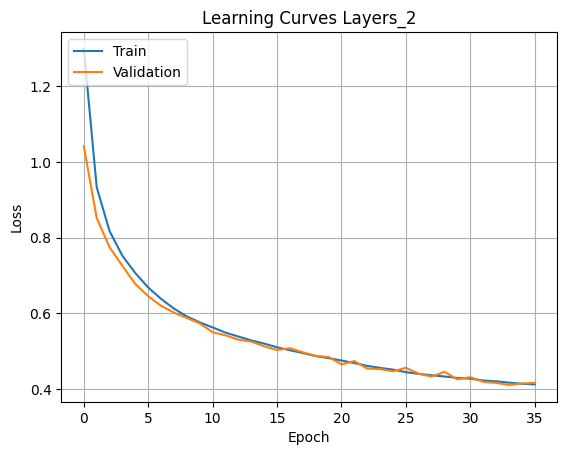

Model: "Layers_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 16)                832       
                                                                 
 dense_83 (Dense)            (None, 16)                272       
                                                                 
 dense_84 (Dense)            (None, 16)                272       
                                                                 
 dense_85 (Dense)            (None, 5)                 85        
                                                                 
Total params: 1461 (5.71 KB)
Trainable params: 1461 (5.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 5ms/step - loss: 1.2695 - accuracy: 0.5499 - val_loss: 0.9616 - val_accuracy: 0.6584
Epoch 2/50
636/6

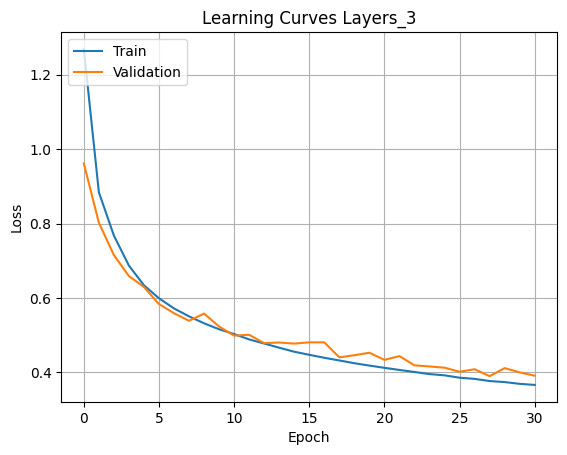

Model: "Layers_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_86 (Dense)            (None, 16)                832       
                                                                 
 dense_87 (Dense)            (None, 16)                272       
                                                                 
 dense_88 (Dense)            (None, 16)                272       
                                                                 
 dense_89 (Dense)            (None, 16)                272       
                                                                 
 dense_90 (Dense)            (None, 5)                 85        
                                                                 
Total params: 1733 (6.77 KB)
Trainable params: 1733 (6.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [======

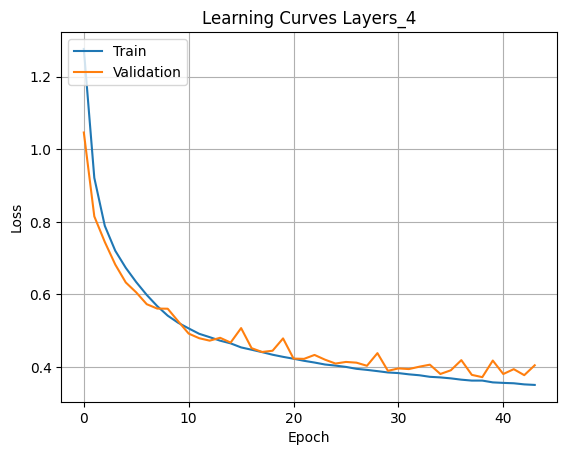

Model: "Layers_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_91 (Dense)            (None, 16)                832       
                                                                 
 dense_92 (Dense)            (None, 16)                272       
                                                                 
 dense_93 (Dense)            (None, 16)                272       
                                                                 
 dense_94 (Dense)            (None, 16)                272       
                                                                 
 dense_95 (Dense)            (None, 16)                272       
                                                                 
 dense_96 (Dense)            (None, 5)                 85        
                                                                 
Total params: 2005 (7.83 KB)
Trainable params: 2005 (7.83 

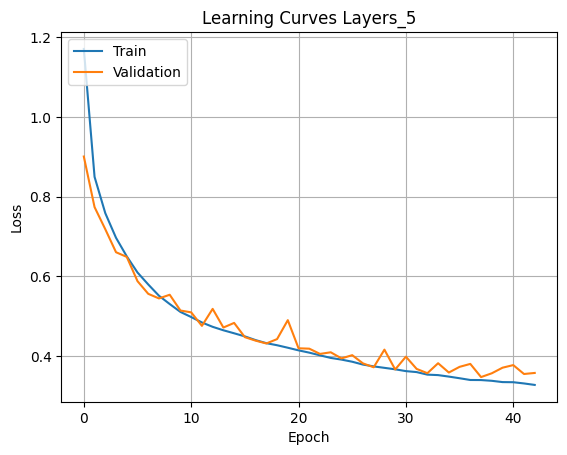

Model: "Layers_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_97 (Dense)            (None, 16)                832       
                                                                 
 dense_98 (Dense)            (None, 16)                272       
                                                                 
 dense_99 (Dense)            (None, 16)                272       
                                                                 
 dense_100 (Dense)           (None, 16)                272       
                                                                 
 dense_101 (Dense)           (None, 16)                272       
                                                                 
 dense_102 (Dense)           (None, 16)                272       
                                                                 
 dense_103 (Dense)           (None, 5)                 85 

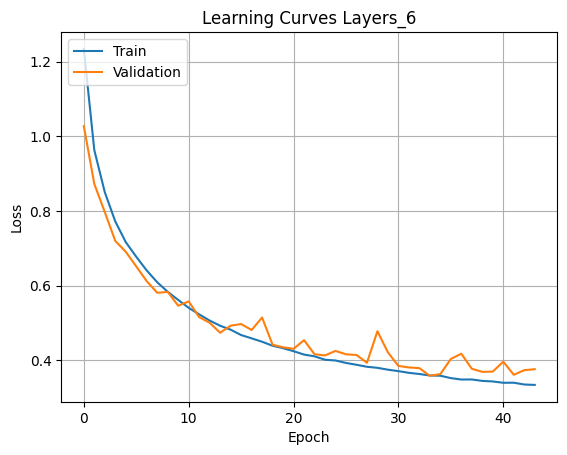

Model: "Layers_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 16)                832       
                                                                 
 dense_105 (Dense)           (None, 16)                272       
                                                                 
 dense_106 (Dense)           (None, 16)                272       
                                                                 
 dense_107 (Dense)           (None, 16)                272       
                                                                 
 dense_108 (Dense)           (None, 16)                272       
                                                                 
 dense_109 (Dense)           (None, 16)                272       
                                                                 
 dense_110 (Dense)           (None, 16)                272

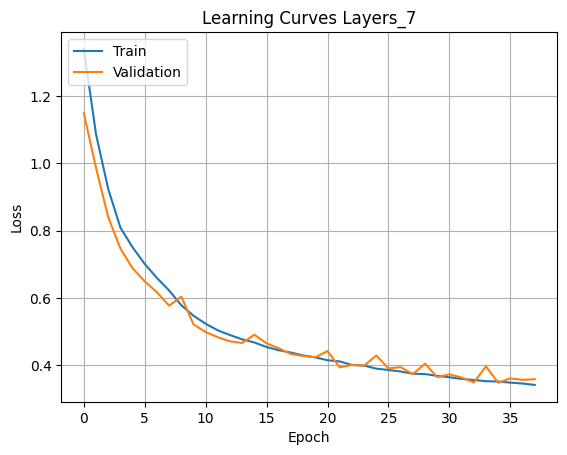

Model: "Layers_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 16)                832       
                                                                 
 dense_113 (Dense)           (None, 16)                272       
                                                                 
 dense_114 (Dense)           (None, 16)                272       
                                                                 
 dense_115 (Dense)           (None, 16)                272       
                                                                 
 dense_116 (Dense)           (None, 16)                272       
                                                                 
 dense_117 (Dense)           (None, 16)                272       
                                                                 
 dense_118 (Dense)           (None, 16)                272

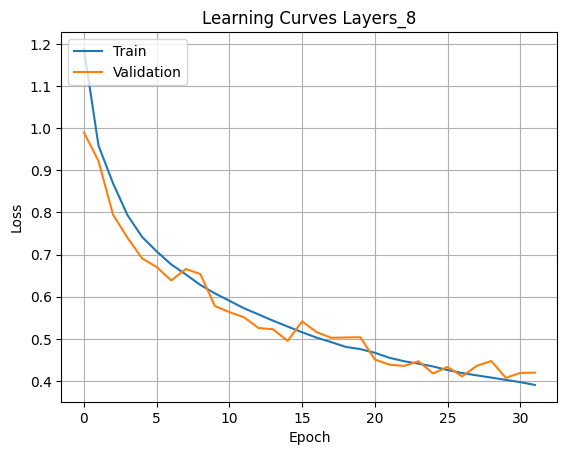

Model: "Layers_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_121 (Dense)           (None, 16)                832       
                                                                 
 dense_122 (Dense)           (None, 16)                272       
                                                                 
 dense_123 (Dense)           (None, 16)                272       
                                                                 
 dense_124 (Dense)           (None, 16)                272       
                                                                 
 dense_125 (Dense)           (None, 16)                272       
                                                                 
 dense_126 (Dense)           (None, 16)                272       
                                                                 
 dense_127 (Dense)           (None, 16)                272

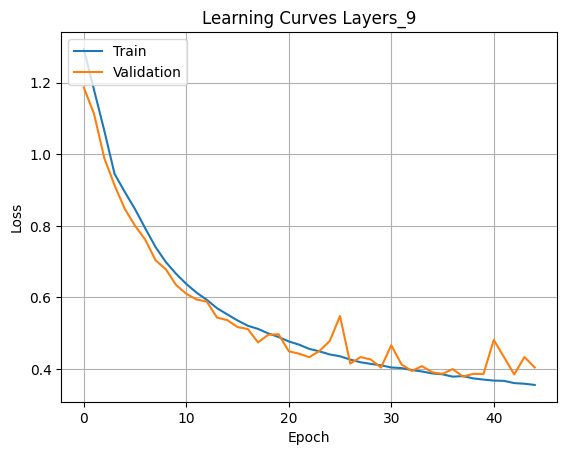

Model: "Layers_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 16)                832       
                                                                 
 dense_132 (Dense)           (None, 16)                272       
                                                                 
 dense_133 (Dense)           (None, 16)                272       
                                                                 
 dense_134 (Dense)           (None, 16)                272       
                                                                 
 dense_135 (Dense)           (None, 16)                272       
                                                                 
 dense_136 (Dense)           (None, 16)                272       
                                                                 
 dense_137 (Dense)           (None, 16)                27

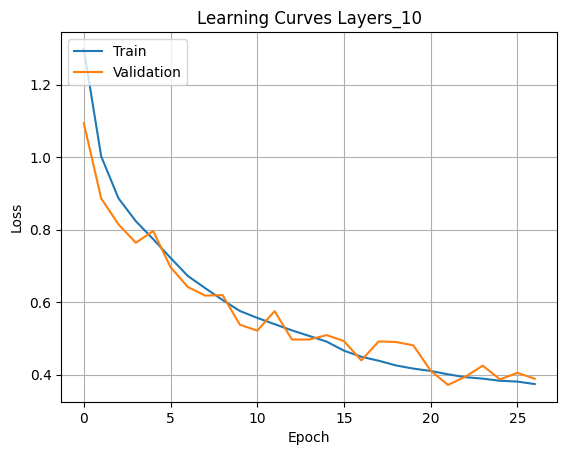

In [ ]:
model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50

accuracy_measures = {}

# reused the previous model config from previous experiment.
# but on this case only increase the number of layers

# I will start small by checking if one or two nodes is enough to get a good result.
layer_list = []
for hidden_layer_count in range(1,11):
  custom_layers = []

  # Simply use 16 nodes per layer for now.

  # Input
  if hidden_layer_count == 1:
    custom_layers.append(layers.Dense(16, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']))
  else:
  # Additional Layers
    custom_layers.append(layers.Dense(16, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']))
    for i in range(1, hidden_layer_count):
      custom_layers.append(layers.Dense(16, activation=model_config['hidden_activation']))

  # Output layers
  custom_layers.append(layers.Dense(model_config['output_nodes'], activation=model_config['output_activation']))

  model_name = 'Layers_' + str(hidden_layer_count)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_hidden_layers = accuracy_measures.copy()

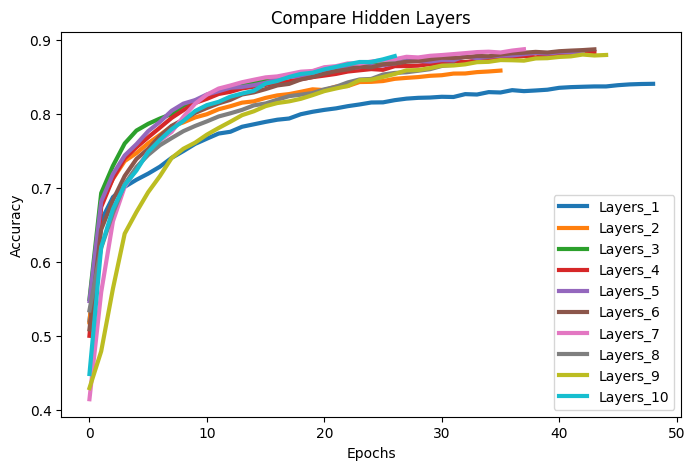

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Hidden Layers")

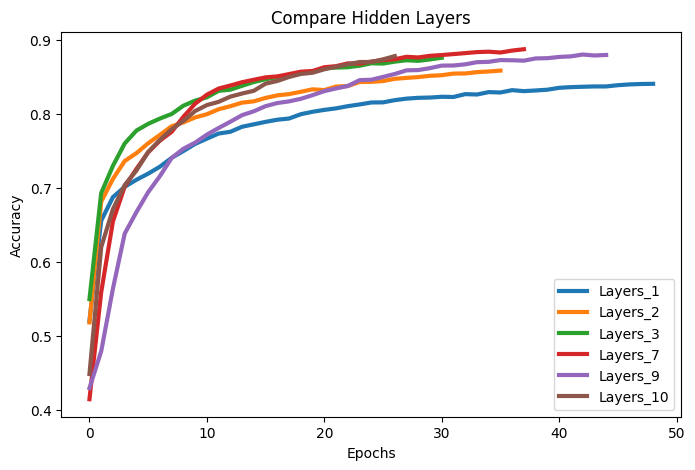

In [ ]:
accuracy_measures_tmp = {}
accuracy_measures_tmp['Layers_1'] = accuracy_measures['Layers_1']
accuracy_measures_tmp['Layers_2'] = accuracy_measures['Layers_2']
accuracy_measures_tmp['Layers_3'] = accuracy_measures['Layers_3']
accuracy_measures_tmp['Layers_7'] = accuracy_measures['Layers_7']
accuracy_measures_tmp['Layers_9'] = accuracy_measures['Layers_9']
accuracy_measures_tmp['Layers_10'] = accuracy_measures['Layers_10']

plot_accuracy_measures(accuracy_measures_tmp, "Compare Hidden Layers")

The Layers_9 Layers_10 completed faster and with higher accuracy but is not stable.
Layer_1 was stable but lower accuracy.
Layer_3 is a good candidate it shows signs of overfitting.
Layer_2 is stable and have a decent accuracy. I will start small by choosing model with 2 layers.

### Determining nodes in a layers
More nodes means more possibility for the model to learn complex relationships. However similar to number of layers, it will results to more training and resources.

On my experiment I started with a low number of 16 nodes.


Model: "Nodes-16-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_169 (Dense)           (None, 16)                832       
                                                                 
 dense_170 (Dense)           (None, 16)                272       
                                                                 
 dense_171 (Dense)           (None, 5)                 85        
                                                                 
Total params: 1189 (4.64 KB)
Trainable params: 1189 (4.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 5s 6ms/step - loss: 1.2631 - accuracy: 0.5350 - val_loss: 0.9916 - val_accuracy: 0.6496
Epoch 2/50
636/636 [==============================] - 3s 5ms/step - loss: 0.9089 - accuracy: 0.6751 - val_loss: 0.8480 - val_accuracy: 0.7036
Epo

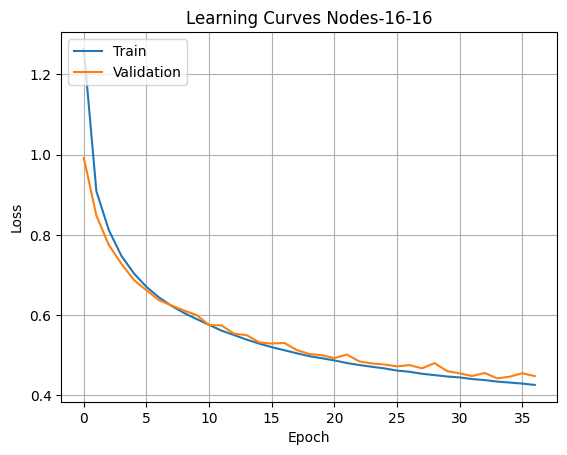

Model: "Nodes-16-24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_172 (Dense)           (None, 16)                832       
                                                                 
 dense_173 (Dense)           (None, 24)                408       
                                                                 
 dense_174 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1365 (5.33 KB)
Trainable params: 1365 (5.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.2127 - accuracy: 0.5831 - val_loss: 0.9428 - val_accuracy: 0.6816
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 0.8753 - accuracy: 0.6959 - val_loss: 0.8087 - val_accuracy: 0.7176
Epo

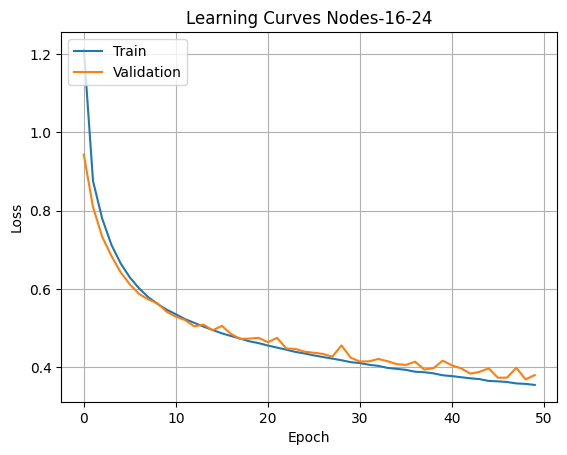

Model: "Nodes-24-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_175 (Dense)           (None, 24)                1248      
                                                                 
 dense_176 (Dense)           (None, 16)                400       
                                                                 
 dense_177 (Dense)           (None, 5)                 85        
                                                                 
Total params: 1733 (6.77 KB)
Trainable params: 1733 (6.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.2270 - accuracy: 0.5367 - val_loss: 0.9380 - val_accuracy: 0.6460
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 0.8709 - accuracy: 0.6855 - val_loss: 0.7979 - val_accuracy: 0.7138
Epo

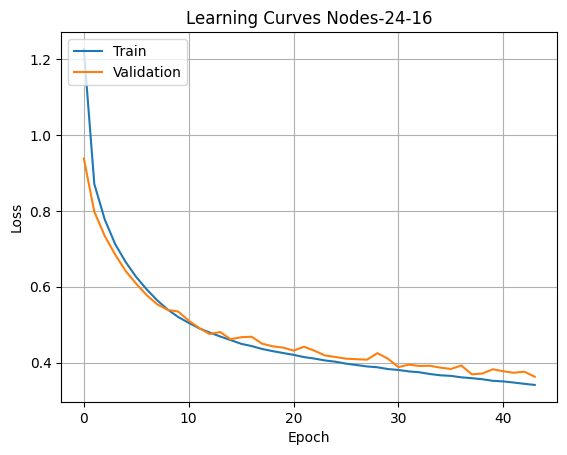

Model: "Nodes-24-24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_178 (Dense)           (None, 24)                1248      
                                                                 
 dense_179 (Dense)           (None, 24)                600       
                                                                 
 dense_180 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.1917 - accuracy: 0.5618 - val_loss: 0.9638 - val_accuracy: 0.6612
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 0.8844 - accuracy: 0.6918 - val_loss: 0.8157 - val_accuracy: 0.7189
Epo

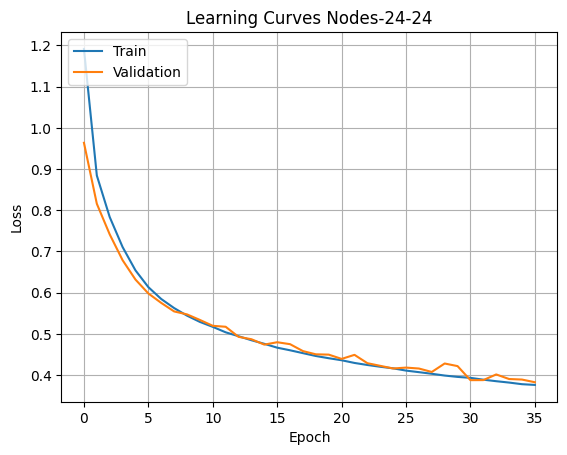

Model: "Nodes-32-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_181 (Dense)           (None, 32)                1664      
                                                                 
 dense_182 (Dense)           (None, 16)                528       
                                                                 
 dense_183 (Dense)           (None, 5)                 85        
                                                                 
Total params: 2277 (8.89 KB)
Trainable params: 2277 (8.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.1523 - accuracy: 0.5989 - val_loss: 0.9160 - val_accuracy: 0.6568
Epoch 2/50
636/636 [==============================] - 3s 5ms/step - loss: 0.8590 - accuracy: 0.6907 - val_loss: 0.8018 - val_accuracy: 0.7070
Epo

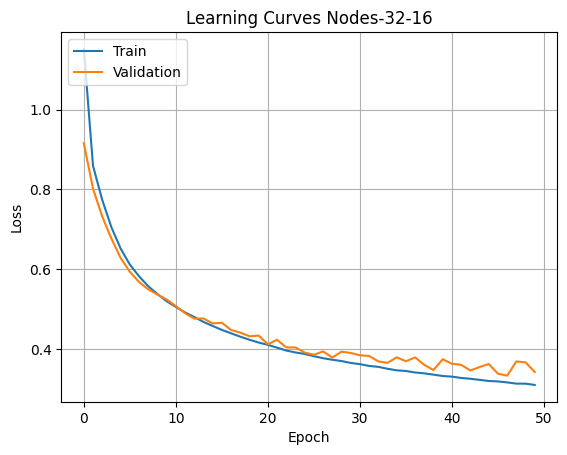

Model: "Nodes-32-24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_184 (Dense)           (None, 32)                1664      
                                                                 
 dense_185 (Dense)           (None, 24)                792       
                                                                 
 dense_186 (Dense)           (None, 5)                 125       
                                                                 
Total params: 2581 (10.08 KB)
Trainable params: 2581 (10.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.1537 - accuracy: 0.5736 - val_loss: 0.9125 - val_accuracy: 0.6712
Epoch 2/50
636/636 [==============================] - 3s 5ms/step - loss: 0.8366 - accuracy: 0.7012 - val_loss: 0.7697 - val_accuracy: 0.7319
E

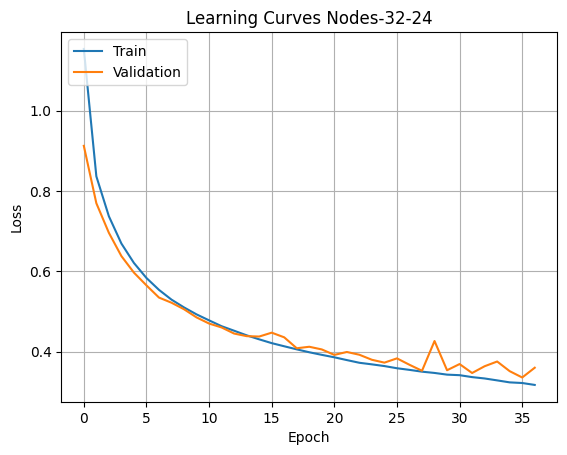

In [ ]:
# reset the accuracy measures
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50

# Exhaustive approach. Try all combinations of layers and the number of nodes;
node_list_layer_1 = [16, 24, 32]
node_list_layer_2 = [16, 24]
#node_list_layer_3 = [16]

for nbr_of_nodes_layer_1 in node_list_layer_1:
  for nbr_of_nodes_layer_2 in node_list_layer_2:
    #for nbr_of_nodes_layer_3 in node_list_layer_3:
        custom_layers = [
          layers.Dense(nbr_of_nodes_layer_1, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
          layers.Dense(nbr_of_nodes_layer_2, activation=model_config['hidden_activation']),
          #layers.Dense(nbr_of_nodes_layer_3, activation=model_config['hidden_activation']),
          layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
        ];
        model_name = 'Nodes-' + str(nbr_of_nodes_layer_1) + '-' + str(nbr_of_nodes_layer_2)
        #model_name = 'Nodes-' + str(nbr_of_nodes_layer_1) + '-' + str(nbr_of_nodes_layer_2) + '-' + str(nbr_of_nodes_layer_3)
        model_config['model_name'] = model_name
        model_config['custom_layers'].clear()
        model_config['custom_layers'].extend(custom_layers)

        history = create_and_run_model(model_config, X_train, y_train_dummy)
        plot_learning_curves(history, model_name)
        accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_nodes = accuracy_measures.copy()

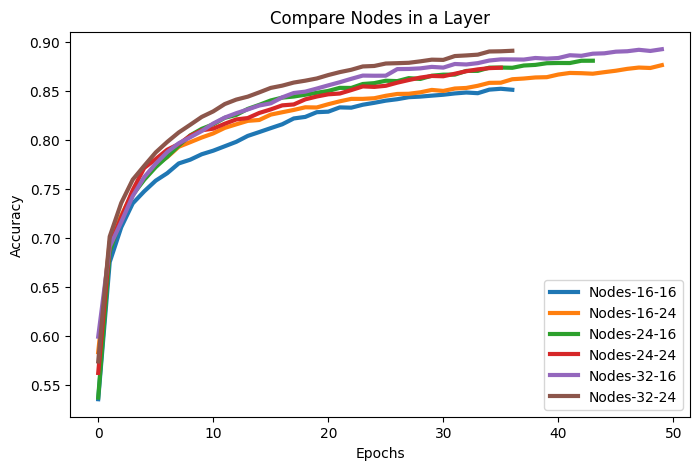

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Nodes in a Layer")

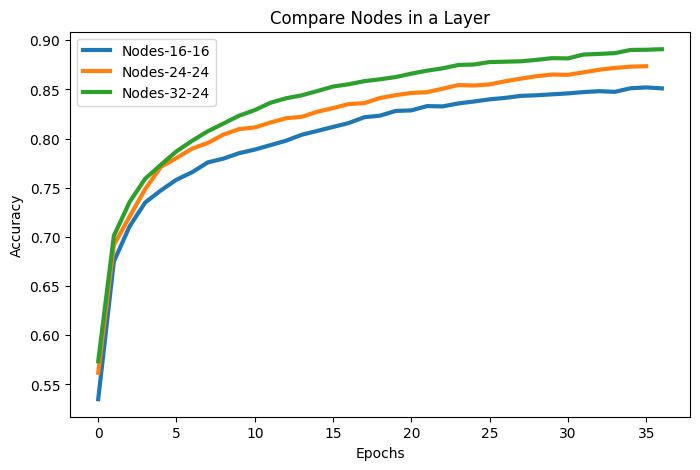

In [ ]:
accuracy_measures_tmp = {}
accuracy_measures_tmp['Nodes-16-16'] = accuracy_measures['Nodes-16-16']
accuracy_measures_tmp['Nodes-24-24'] = accuracy_measures['Nodes-24-24']
accuracy_measures_tmp['Nodes-32-24'] = accuracy_measures['Nodes-32-24']

plot_accuracy_measures(accuracy_measures_tmp, "Compare Nodes in a Layer")

The model Nodes-32-24 result to higher accuracy but shows signs of overfitting. The model Nodes-16-16 was table but have a lower accuracy.
The model Nodes-24-24 offer a good balance of accuracy and stability among the models.

### Choosing Activation Function

There are number of algorithms available for activation functions. In general, rectified linear unit works best for regular  artificial neural network (ANN) and convolutional network (CNN). Sigmoid works best for RNNs.


Model: "Model-relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_214 (Dense)           (None, 24)                1248      
                                                                 
 dense_215 (Dense)           (None, 24)                600       
                                                                 
 dense_216 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 5ms/step - loss: 1.2074 - accuracy: 0.5374 - val_loss: 0.9435 - val_accuracy: 0.6537
Epoch 2/50
636/636 [==============================] - 4s 6ms/step - loss: 0.8686 - accuracy: 0.6835 - val_loss: 0.8099 - val_accuracy: 0.7103
Epoc

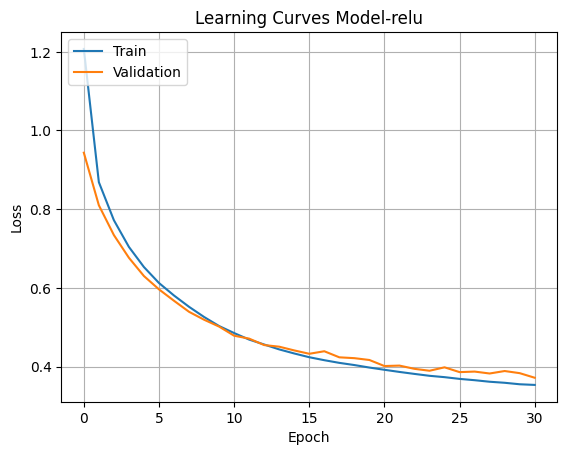

Model: "Model-sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_217 (Dense)           (None, 24)                1248      
                                                                 
 dense_218 (Dense)           (None, 24)                600       
                                                                 
 dense_219 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.5475 - accuracy: 0.3785 - val_loss: 1.4269 - val_accuracy: 0.4762
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 1.2874 - accuracy: 0.5045 - val_loss: 1.1654 - val_accuracy: 0.5810
E

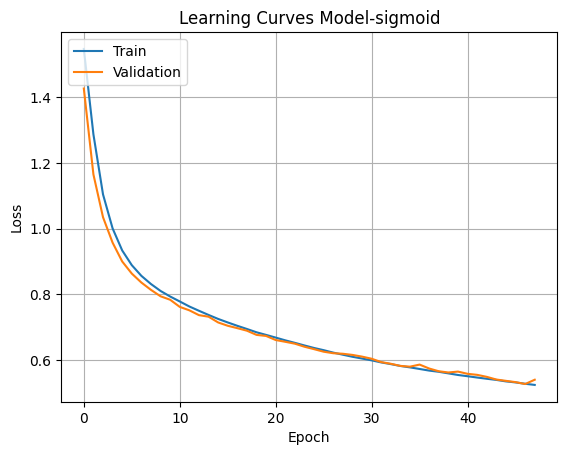

Model: "Model-tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_220 (Dense)           (None, 24)                1248      
                                                                 
 dense_221 (Dense)           (None, 24)                600       
                                                                 
 dense_222 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 6ms/step - loss: 1.0765 - accuracy: 0.6218 - val_loss: 0.8518 - val_accuracy: 0.6873
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 0.8098 - accuracy: 0.7056 - val_loss: 0.7666 - val_accuracy: 0.7184
Epoc

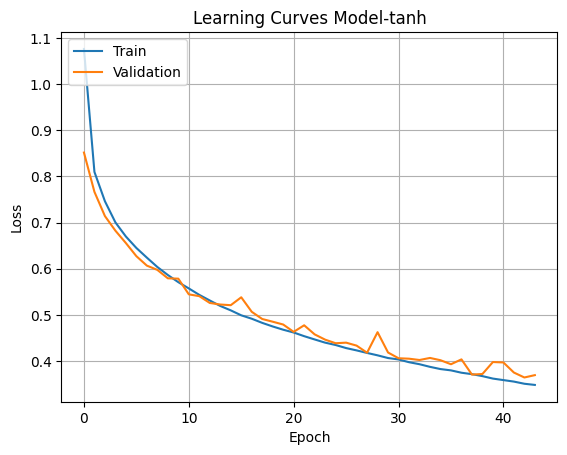

In [ ]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 2
# Number of nodes per each layer: 24-24

activation_list = ['relu','sigmoid','tanh']

for activation in activation_list:

  model_config['hidden_activation'] = activation

  custom_layers = [
    layers.Dense(24, activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(24, activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Model-' + activation
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_activation = accuracy_measures.copy()

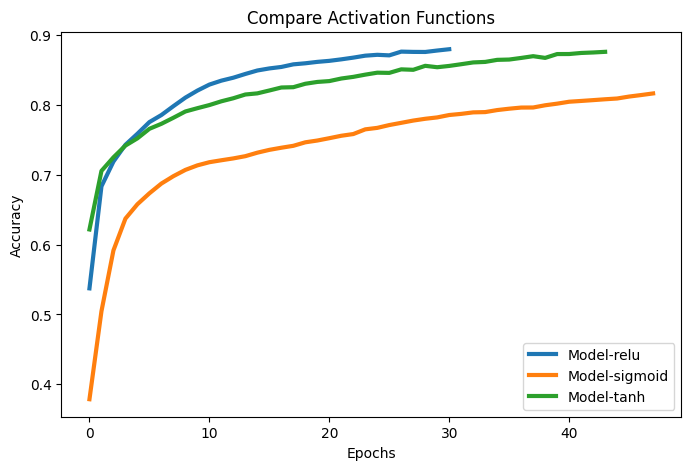

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Activation Functions")

The activation function relu have higher accuracy and completed faster.

In [ ]:
model_config['hidden_activation'] = 'relu'

### Initialize Weights
The initial values of weights play a huge role in the speed of learning and finaly accuracy. Multiple initialization techniques exist.

Random normal works best for most cases but we will run an experiment if that is still the case on our dataset.

Model: "Model-random_normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_223 (Dense)           (None, 24)                1248      
                                                                 
 dense_224 (Dense)           (None, 24)                600       
                                                                 
 dense_225 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 6ms/step - loss: 1.2255 - accuracy: 0.5372 - val_loss: 0.9506 - val_accuracy: 0.6586
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 0.8902 - accuracy: 0.6822 - val_loss: 0.8291 - val_accuracy: 0.

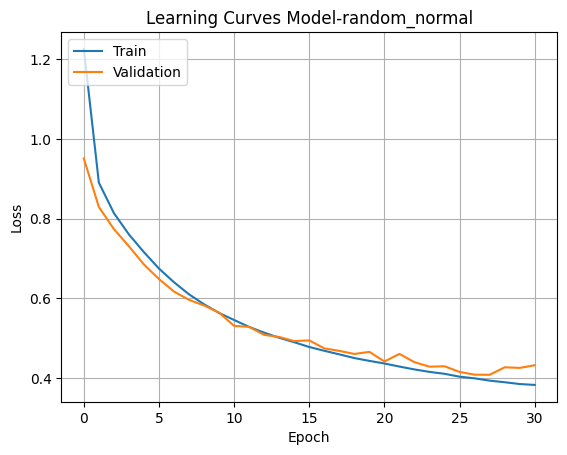

Model: "Model-random_uniform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_226 (Dense)           (None, 24)                1248      
                                                                 
 dense_227 (Dense)           (None, 24)                600       
                                                                 
 dense_228 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.2744 - accuracy: 0.5081 - val_loss: 1.0436 - val_accuracy: 0.6079
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 0.9706 - accuracy: 0.6395 - val_loss: 0.8900 - val_accuracy: 0

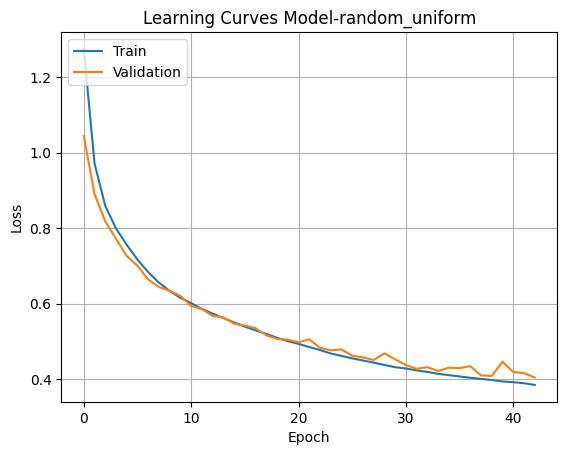

In [ ]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 2
# Number of nodes per each layer: 24-24
model_config['hidden_activation'] = 'relu'

initializer_list = ['random_normal', "random_uniform"]

for initializer in initializer_list:

  model_config['weights_initializer'] = initializer

  custom_layers = [
    layers.Dense(24, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(24, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Model-' + initializer
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_weight_init = accuracy_measures.copy()

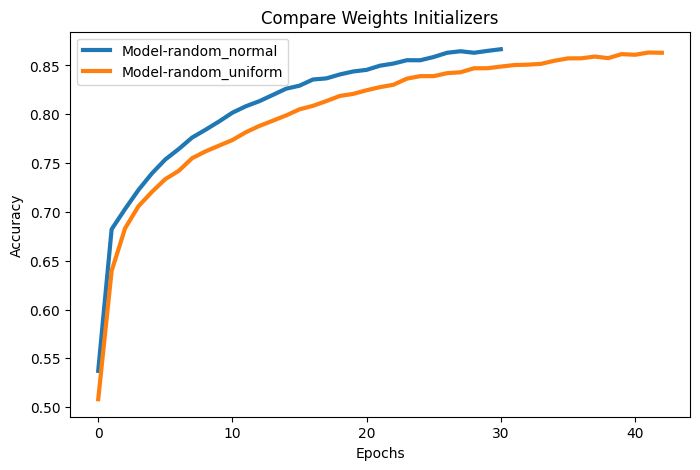

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Weights Initializers")

Even though random_uniform completed faster, the random_normal result to higher accuracy thus choosing random_normal as weight initializer.

In [ ]:
model_config['weights_initializer'] = 'random_normal'

## Tuning Back Propagation

### Batch Normalization

Batch normalization is an important technique to vanishing and exploiting gradients during gradient descent. Batch normalization help achieve higher accuracies with lower epochs, hence is also an optimization technique.

*This is no longer necessary because Scaler was already applied during data preparation. However, in order to show the difference, I am also running this experiment.*

Model: "Normalization-batch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_229 (Dense)           (None, 24)                1248      
                                                                 
 batch_normalization_2 (Bat  (None, 24)                96        
 chNormalization)                                                
                                                                 
 dense_230 (Dense)           (None, 24)                600       
                                                                 
 batch_normalization_3 (Bat  (None, 24)                96        
 chNormalization)                                                
                                                                 
 dense_231 (Dense)           (None, 5)                 125       
                                                                 
Total params: 2165 (8.46 KB)
Trainable params: 

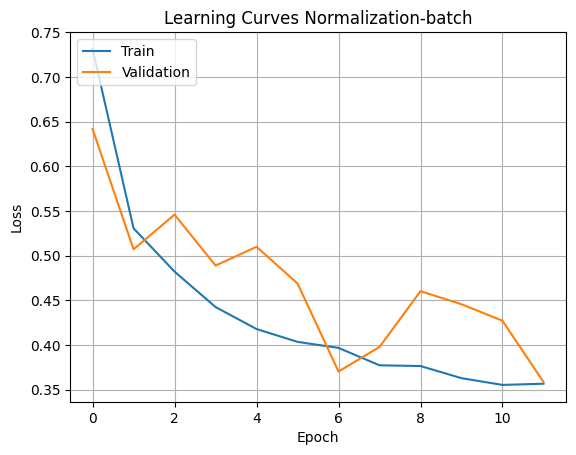

Model: "Normalization-none"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_232 (Dense)           (None, 24)                1248      
                                                                 
 dense_233 (Dense)           (None, 24)                600       
                                                                 
 dense_234 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.2285 - accuracy: 0.5616 - val_loss: 0.9632 - val_accuracy: 0.6513
Epoch 2/50
636/636 [==============================] - 3s 5ms/step - loss: 0.8889 - accuracy: 0.6789 - val_loss: 0.8248 - val_accuracy: 0.7

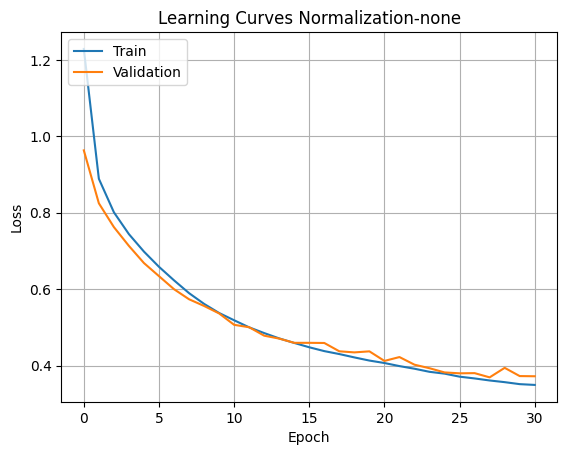

In [ ]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 2
# Number of nodes per each layer: 24-24
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_normal'

normalization_list = ['batch','none']
for normalization in normalization_list:

  custom_layers = []
  if normalization == 'none':
    custom_layers = [
      layers.Dense(24, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(24, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];
  else:
    custom_layers = [
      layers.Dense(24, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.BatchNormalization(),
      layers.Dense(24, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.BatchNormalization(),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ];


  model_name = 'Normalization-' + normalization
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_normalization = accuracy_measures.copy()

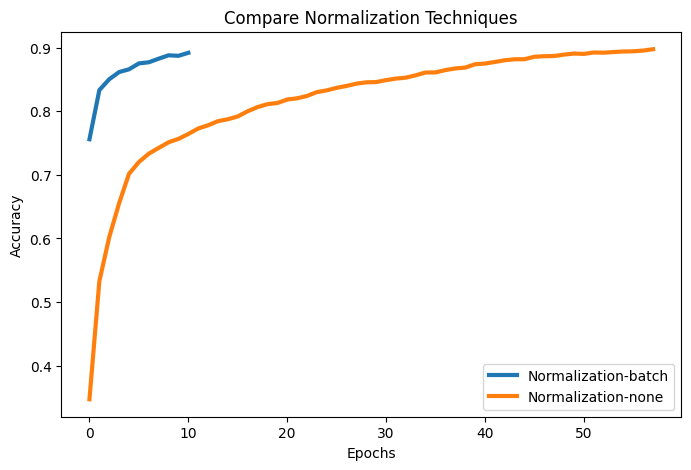

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Normalization Techniques")

Not applying a normalization layer results to a better result.

### Optimizers
Optimizer are key tools, that help gradient descent, achieve faster results. Optimizers are algorithms, that helps speed up the training process.

Model: "Optimizer-sgd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_235 (Dense)           (None, 24)                1248      
                                                                 
 dense_236 (Dense)           (None, 24)                600       
                                                                 
 dense_237 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.2413 - accuracy: 0.5451 - val_loss: 0.9723 - val_accuracy: 0.6425
Epoch 2/50
636/636 [==============================] - 2s 4ms/step - loss: 0.9061 - accuracy: 0.6646 - val_loss: 0.8485 - val_accuracy: 0.6956
E

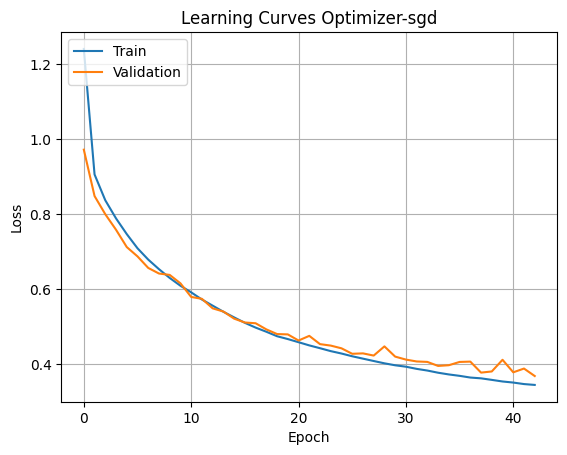

Model: "Optimizer-rmsprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_238 (Dense)           (None, 24)                1248      
                                                                 
 dense_239 (Dense)           (None, 24)                600       
                                                                 
 dense_240 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.2415 - accuracy: 0.5203 - val_loss: 0.9733 - val_accuracy: 0.6511
Epoch 2/50
636/636 [==============================] - 2s 4ms/step - loss: 0.8988 - accuracy: 0.6809 - val_loss: 0.8336 - val_accuracy: 0.70

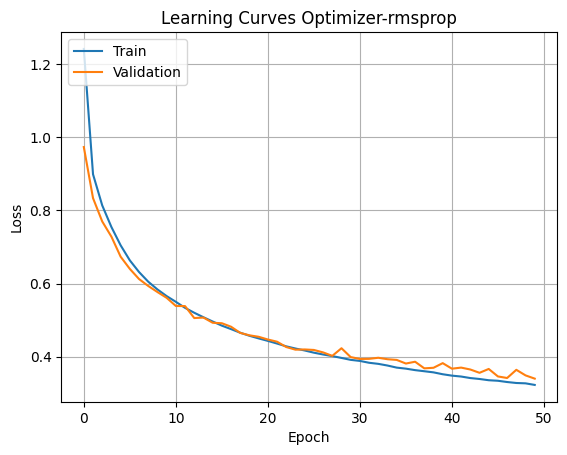

Model: "Optimizer-adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_241 (Dense)           (None, 24)                1248      
                                                                 
 dense_242 (Dense)           (None, 24)                600       
                                                                 
 dense_243 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 5ms/step - loss: 1.2883 - accuracy: 0.5144 - val_loss: 1.0342 - val_accuracy: 0.6046
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 0.9284 - accuracy: 0.6533 - val_loss: 0.8543 - val_accuracy: 0.6893


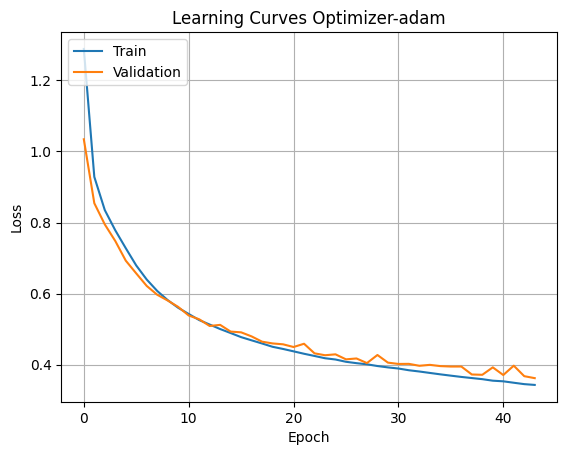

Model: "Optimizer-adagrad"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_244 (Dense)           (None, 24)                1248      
                                                                 
 dense_245 (Dense)           (None, 24)                600       
                                                                 
 dense_246 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 4ms/step - loss: 1.6071 - accuracy: 0.2388 - val_loss: 1.6049 - val_accuracy: 0.2472
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 1.6037 - accuracy: 0.2870 - val_loss: 1.6011 - val_accuracy: 0.32

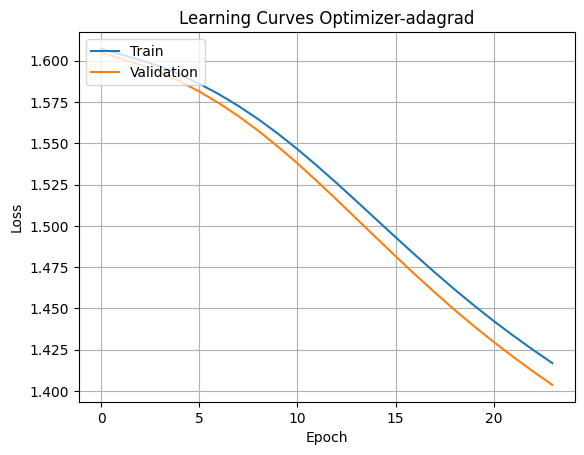

In [ ]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 2
# Number of nodes per each layer: 24-24
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_normal'
# Batch Normalization: not added

optimizer_list = ['sgd','rmsprop','adam','adagrad']

for optimizer in optimizer_list:

  model_config['optimizer'] = optimizer

  custom_layers = [
    layers.Dense(24, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(24, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Optimizer-' + optimizer
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_optimizer = accuracy_measures.copy()

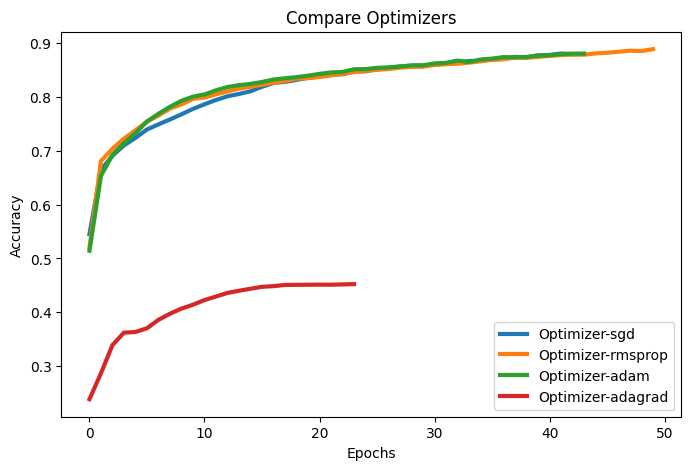

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Optimizers")

There are two possible good candidates for optimizer. The Optimizer-rmsprop and Optimizer-adam both offer similar accuracy but Optimizer-adam completed with fewer epoch thus using adam as optimizer.

In [ ]:
model_config['optimizer'] = 'adam'

### Learning Rates

Learning rate is the rate at  which the weights will change in response to the estimated error. It is the speed at which the model is expected to learn from the training data and adjust its weights. Learning rates work in conjunction with the optimizer.

Model: "Learning-Rate-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_247 (Dense)           (None, 24)                1248      
                                                                 
 dense_248 (Dense)           (None, 24)                600       
                                                                 
 dense_249 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 5ms/step - loss: 1.2194 - accuracy: 0.5588 - val_loss: 0.9739 - val_accuracy: 0.6449
Epoch 2/50
636/636 [==============================] - 2s 4ms/step - loss: 0.8988 - accuracy: 0.6687 - val_loss: 0.8319 - val_accuracy: 0.

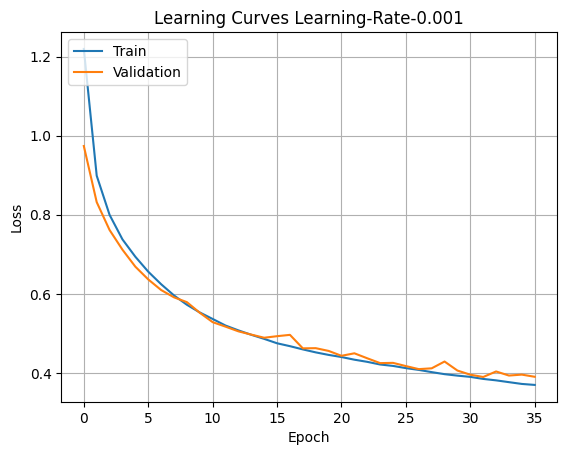

Model: "Learning-Rate-0.005"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_250 (Dense)           (None, 24)                1248      
                                                                 
 dense_251 (Dense)           (None, 24)                600       
                                                                 
 dense_252 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 0.9594 - accuracy: 0.6310 - val_loss: 0.7688 - val_accuracy: 0.7107
Epoch 2/50
636/636 [==============================] - 3s 5ms/step - loss: 0.7055 - accuracy: 0.7366 - val_loss: 0.6315 - val_accuracy: 0.

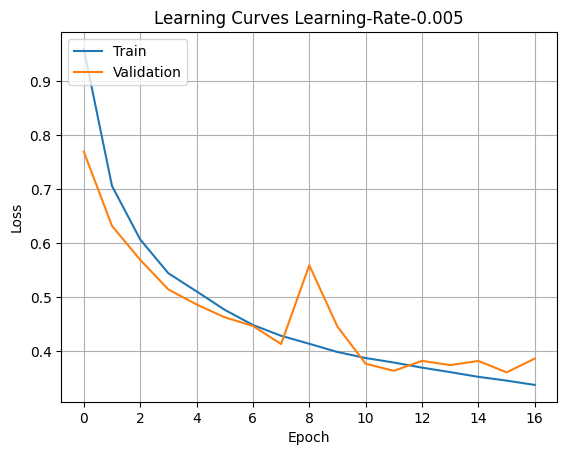

Model: "Learning-Rate-0.01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_253 (Dense)           (None, 24)                1248      
                                                                 
 dense_254 (Dense)           (None, 24)                600       
                                                                 
 dense_255 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 0.9885 - accuracy: 0.6218 - val_loss: 0.7768 - val_accuracy: 0.7166
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 0.7121 - accuracy: 0.7363 - val_loss: 0.6421 - val_accuracy: 0.7

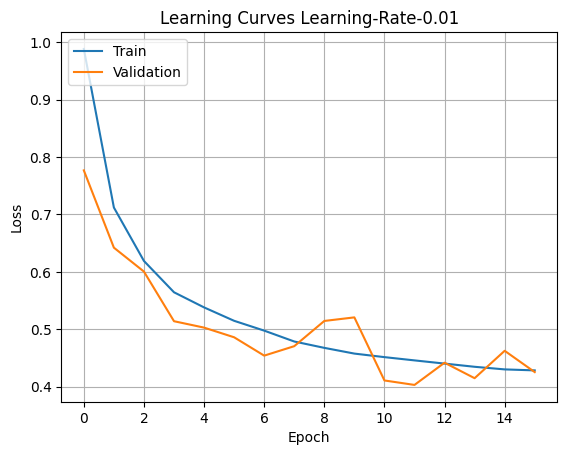

Model: "Learning-Rate-0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_256 (Dense)           (None, 24)                1248      
                                                                 
 dense_257 (Dense)           (None, 24)                600       
                                                                 
 dense_258 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 5ms/step - loss: 1.6557 - accuracy: 0.2059 - val_loss: 1.6092 - val_accuracy: 0.2140
Epoch 2/50
636/636 [==============================] - 4s 6ms/step - loss: 1.6154 - accuracy: 0.2099 - val_loss: 1.6083 - val_accuracy: 0.21

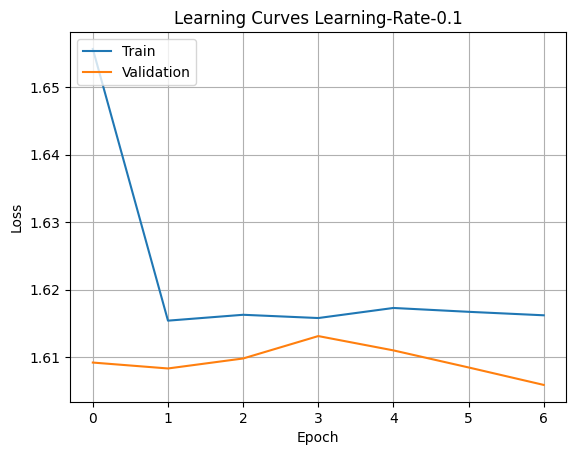

In [ ]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 2
# Number of nodes per each layer: 24-24
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_normal'
# Batch Normalization: not added
model_config['optimizer'] = 'adam'

learning_rate_list = [0.001, 0.005, 0.01, 0.1]

for learning_rate in learning_rate_list:

  model_config['learning_rate'] = learning_rate

  custom_layers = [
    layers.Dense(24, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(24, kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Learning-Rate-' + str(learning_rate)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)
  accuracy_measures[model_name] = history.history['accuracy']

In [ ]:
accuracy_measures_learning_rate = accuracy_measures.copy()

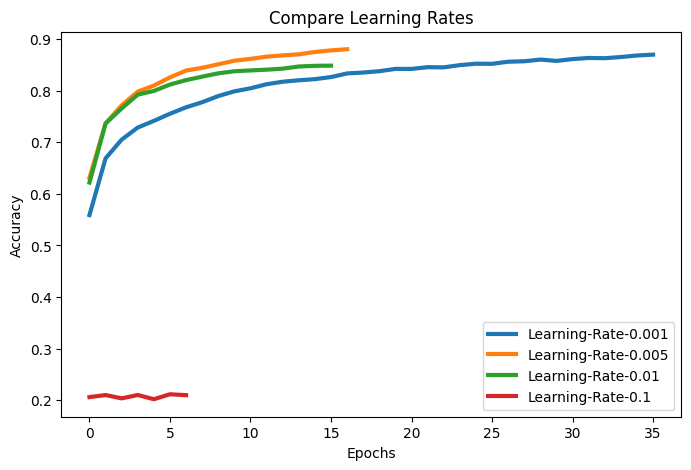

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Learning Rates")

The learning rate 0.01 and 0.005 offers a higher accuracy but it is unstable compared to 0.001. Thus, selecting the model with a learning rate of 0.001

In [ ]:
model_config['learning_rate'] = 0.001

## Overfitting Management

### Regularization
Regularization is an important technique for managing overfitting in neural networks. Regularization algorithms provide an adjustments to the model parameters after they are updated. The adjustment reduces the variance in the model by providing a penalty when overfitting.

Testing: l1
Model: "Regularizer-l1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_259 (Dense)           (None, 24)                1248      
                                                                 
 dense_260 (Dense)           (None, 24)                600       
                                                                 
 dense_261 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 5ms/step - loss: 1.6437 - accuracy: 0.2150 - val_loss: 1.6144 - val_accuracy: 0.2140
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 1.6160 - accuracy: 0.2159 - val_loss: 1.6149 - val_accur

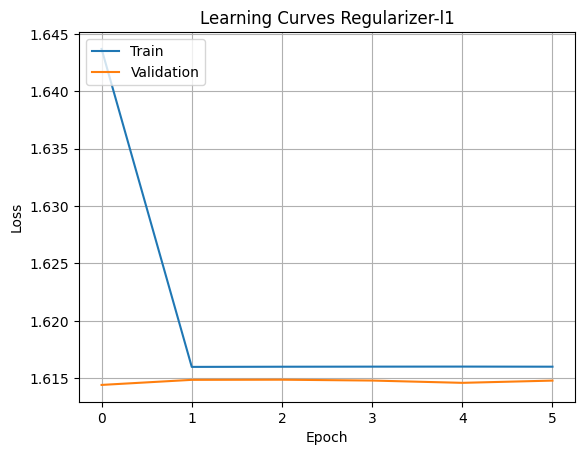

Testing: l2
Model: "Regularizer-l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_262 (Dense)           (None, 24)                1248      
                                                                 
 dense_263 (Dense)           (None, 24)                600       
                                                                 
 dense_264 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.4273 - accuracy: 0.4420 - val_loss: 1.2950 - val_accuracy: 0.5462
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 1.2619 - accuracy: 0.5565 - val_loss: 1.2170 - val_accur

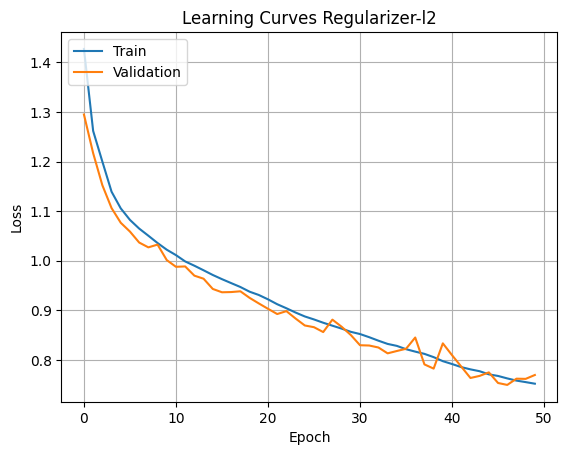

Testing: l1_l2
Model: "Regularizer-l1_l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_265 (Dense)           (None, 24)                1248      
                                                                 
 dense_266 (Dense)           (None, 24)                600       
                                                                 
 dense_267 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 4ms/step - loss: 1.6468 - accuracy: 0.2143 - val_loss: 1.6146 - val_accuracy: 0.2140
Epoch 2/50
636/636 [==============================] - 3s 4ms/step - loss: 1.6162 - accuracy: 0.2153 - val_loss: 1.6148 - val

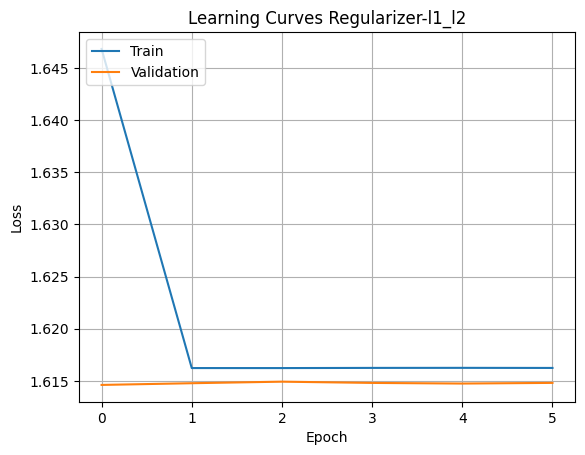

Testing: None
Model: "Regularizer-None"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_268 (Dense)           (None, 24)                1248      
                                                                 
 dense_269 (Dense)           (None, 24)                600       
                                                                 
 dense_270 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 4s 5ms/step - loss: 1.3225 - accuracy: 0.4952 - val_loss: 1.1006 - val_accuracy: 0.5951
Epoch 2/50
636/636 [==============================] - 3s 5ms/step - loss: 0.9706 - accuracy: 0.6601 - val_loss: 0.8569 - val_a

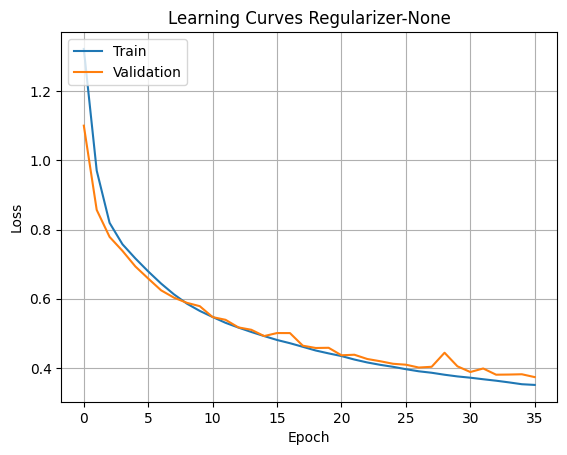

In [ ]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 2
# Number of nodes per each layer: 24-24
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_normal'
# Batch Normalization: not added
model_config['optimizer'] = 'adam'
model_config['learning_rate'] = 0.001

regularizer_list = ['l1','l2','l1_l2', 'None']

for regularizer in regularizer_list:
  if regularizer == 'None':
    regularizer = None

  model_config['regularizer'] = regularizer
  print('Testing: {}'.format(regularizer))

  custom_layers = [
    layers.Dense(24, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dense(24, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ];

  model_name = 'Regularizer-' + str(regularizer)
  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)

  # Used the validation accuracy
  accuracy_measures[model_name] = history.history['val_accuracy']

In [ ]:
accuracy_measures_regularizer = accuracy_measures.copy()

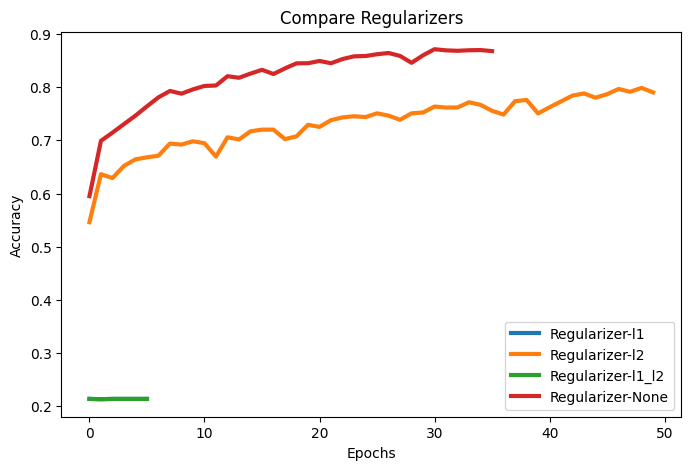

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Regularizers")

Similar to Batch Normalization, adding regularization does not improve performance and instead produce unstability to the model. Hence, not applying any regularizer to the model is the better option.

In [ ]:
model_config['regularizer'] = None

### Dropout
Dropout works during forward propagation. By default, during forward propagation, the  output of each node in the layer is sent every node in the next layer. When using dropout, the outputs of some of the nodes in the layer are dropped randomly.

Model: "Dropout-None"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_271 (Dense)           (None, 24)                1248      
                                                                 
 dense_272 (Dense)           (None, 24)                600       
                                                                 
 dense_273 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==============================] - 3s 4ms/step - loss: 1.2333 - accuracy: 0.5797 - val_loss: 0.9494 - val_accuracy: 0.6771
Epoch 2/50
636/636 [==============================] - 3s 5ms/step - loss: 0.8893 - accuracy: 0.6879 - val_loss: 0.8212 - val_accuracy: 0.7062
Ep

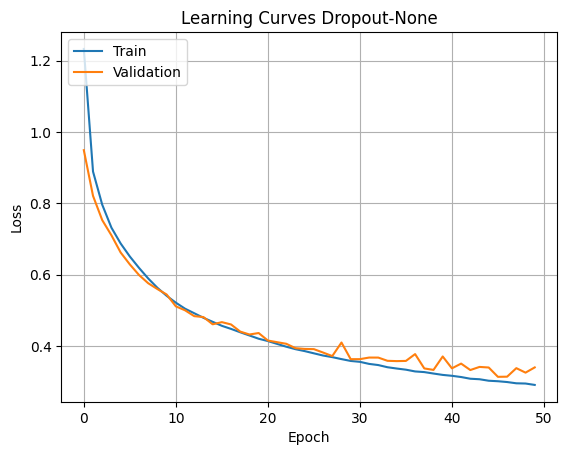

Model: "Dropout0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_274 (Dense)           (None, 24)                1248      
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_275 (Dense)           (None, 24)                600       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_276 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [==

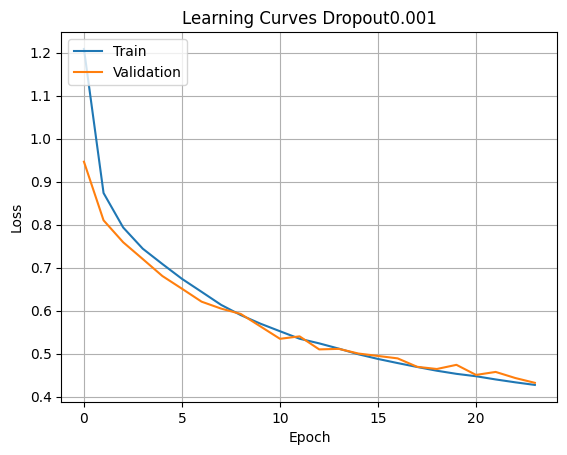

Model: "Dropout0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_277 (Dense)           (None, 24)                1248      
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_278 (Dense)           (None, 24)                600       
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_279 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [====

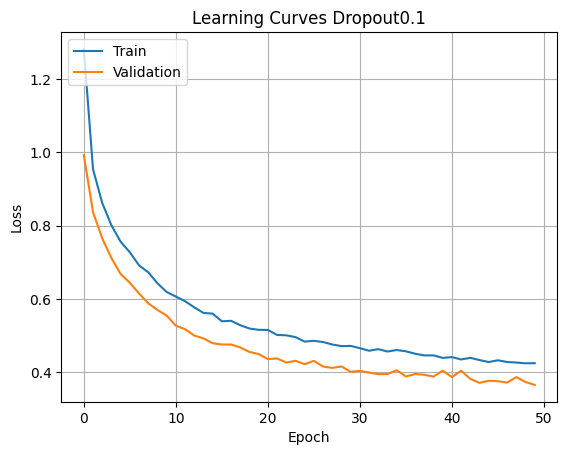

Model: "Dropout0.2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_280 (Dense)           (None, 24)                1248      
                                                                 
 dropout_4 (Dropout)         (None, 24)                0         
                                                                 
 dense_281 (Dense)           (None, 24)                600       
                                                                 
 dropout_5 (Dropout)         (None, 24)                0         
                                                                 
 dense_282 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [====

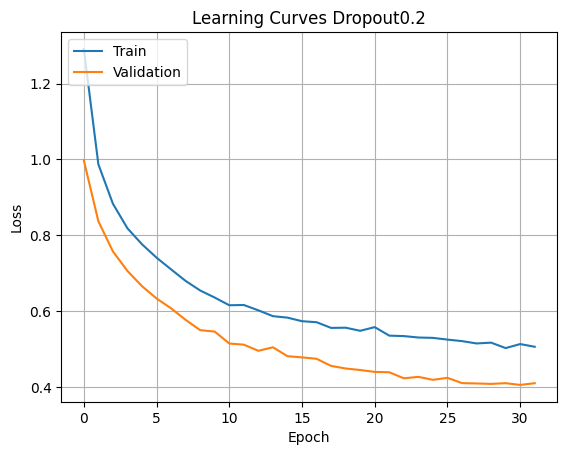

Model: "Dropout0.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_283 (Dense)           (None, 24)                1248      
                                                                 
 dropout_6 (Dropout)         (None, 24)                0         
                                                                 
 dense_284 (Dense)           (None, 24)                600       
                                                                 
 dropout_7 (Dropout)         (None, 24)                0         
                                                                 
 dense_285 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
636/636 [====

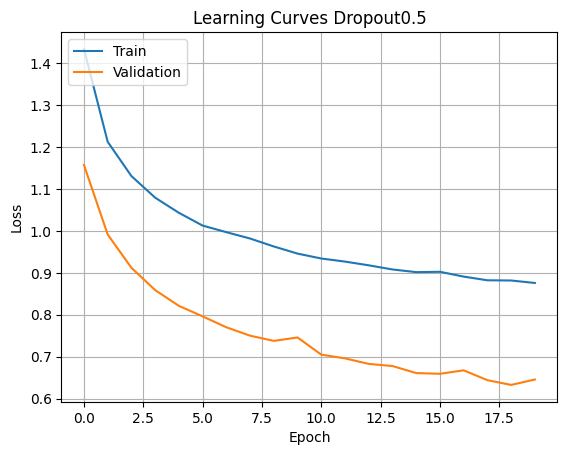

In [ ]:
accuracy_measures = {}

model_config = get_base_model_config()
# Hyperparameters:
model_config['batch_size'] = 32
model_config['epochs'] = 50
# Number of layers: 2
# Number of nodes per each layer: 24-24
model_config['hidden_activation'] = 'relu'
model_config['weights_initializer'] = 'random_normal'
# Batch Normalization: not added
model_config['optimizer'] = 'adam'
model_config['learning_rate'] = 0.001
model_config['regularizer'] = None
model_config['dropout_rate'] = None

dropout_list = [0.0, 0.001, 0.1, 0.2, 0.5]

for dropout in dropout_list:

  model_config['dropout_rate'] = dropout

  custom_layers = []

  if model_config['dropout_rate'] > 0.0:
    model_name = 'Dropout' + str(dropout)
    custom_layers = [
      layers.Dense(24, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(24, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dropout(model_config['dropout_rate']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ]
  else:
    model_name = 'Dropout-None'
    custom_layers = [
      layers.Dense(24, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
      layers.Dense(24, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
      layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
    ]

  model_config['model_name'] = model_name
  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  history = create_and_run_model(model_config, X_train, y_train_dummy)
  plot_learning_curves(history, model_name)

  # Used the validation accuracy
  accuracy_measures[model_name] = history.history['val_accuracy']

In [ ]:
accuracy_measures_dropout = accuracy_measures.copy()

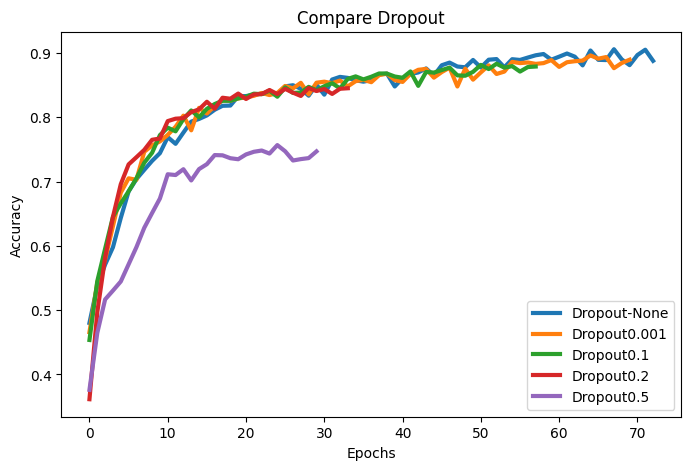

In [ ]:
plot_accuracy_measures(accuracy_measures, "Compare Dropout")

The result of dropout experiment shows a close result between Dropout-None and Dropout0.001. I will choose the model Dropout0.001 because of small reduction in overfitting but slightly higher accuracy.

In [ ]:
model_config['dropout_rate'] = 0.001

# Model - Evaluation

In [ ]:
def get_best_param_model_config(model_name):
  """
  (str) -> dict

  This method returns the best hyper parameters from experiments.

  Parameters
  ----------
  model_name - The name of the model

  Returns
  ----------
  dict - The dictionary containing the best hyper parameters from experiments.
  """
  # Default model config
  model_config = get_base_model_config()

  model_config['model_name'] = model_name

  # Include F1-Score in the metrics so we can use that score during evaluation
  model_config['metrics'] = ['accuracy', F1Score(average='macro')], # set the average so the F1-Score will not return an array per each individual classes.

  # These are the final hyperparameters that I will use in training the Models:
  # Hyperparameters:
  model_config['batch_size'] = 32
  model_config['epochs'] = 50
  # Number of layers: 3
  # Number of nodes per each layer: 32-16-16
  model_config['hidden_activation'] = 'relu'
  model_config['weights_initializer'] = 'random_normal'
  # Batch Normalization: not added
  model_config['optimizer'] = 'adam'
  model_config['learning_rate'] = 0.001
  model_config['regularizer'] = None
  model_config['dropout_rate'] = 0.001

  custom_layers = [
    layers.Dense(24, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation'], input_dim=model_config['input_dim']),
    layers.Dropout(model_config['dropout_rate']),
    layers.Dense(24, kernel_regularizer=model_config['regularizer'], kernel_initializer=model_config['weights_initializer'], activation=model_config['hidden_activation']),
    layers.Dropout(model_config['dropout_rate']),
    layers.Dense(model_config['output_nodes'], activation=model_config['output_activation'])
  ]

  model_config['custom_layers'].clear()
  model_config['custom_layers'].extend(custom_layers)

  # we would like to save the model starting here for evaluation.
  model_config['is_save_model'] = True

  return model_config

In [ ]:
from keras.models import load_model

def evaluate_model(model_config, X, y):
  """
  (dict, tf.data.Dataset)

  This is a reusable function that load a previously trained model and run an evaluation.

  Parameters
  ----------
  model_config - The dictionary to use in model evaluation.
  test_ds - The test dataset to use in the evaluation.

  Returns
  ----------
  Dataframe - The Panda Dataframe containing the scores from the experiment. The scores includes the Accuracy and Loss.
  """
  model_file = str(model_config['workspace_path']) + str(model_config['model_name']) + '.h5'
  model = load_model(model_file)

  test_loss, test_accuracy, test_f1_score = model.evaluate(X, y, verbose=model_config['verbose'])
  print(f"Test accuracy: {test_accuracy}, Test F1-Score: {test_f1_score}")

In [ ]:
# reset accuracy measures
accuracy_measures = {}

In [ ]:
model_name = 'Multiclass_Clarissification_of_Malicious_URL'
best_param_model_config = get_best_param_model_config(model_name)

In [ ]:
best_model_history = create_and_run_model(best_param_model_config, X_train, y_train_dummy)

Model: "Multiclass_Clarissification_of_Malicious_URL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_292 (Dense)           (None, 24)                1248      
                                                                 
 dropout_12 (Dropout)        (None, 24)                0         
                                                                 
 dense_293 (Dense)           (None, 24)                600       
                                                                 
 dropout_13 (Dropout)        (None, 24)                0         
                                                                 
 dense_294 (Dense)           (None, 5)                 125       
                                                                 
Total params: 1973 (7.71 KB)
Trainable params: 1973 (7.71 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________

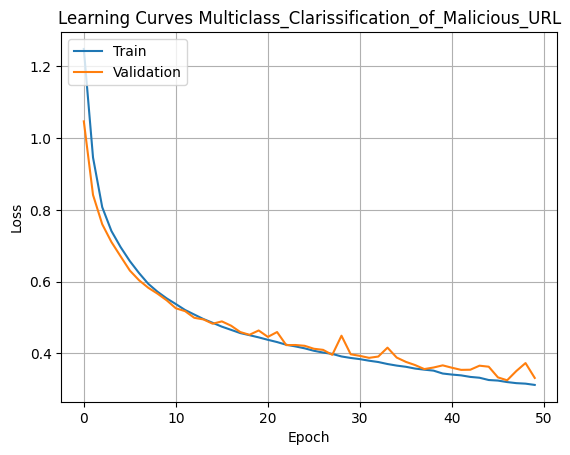

In [ ]:
plot_learning_curves(best_model_history, model_name)

In [ ]:
evaluate_model(best_param_model_config, X_test, y_test_dummy)

341/341 [==============================] - 1s 3ms/step - loss: 0.3266 - accuracy: 0.8869 - f1_score: 0.8860
Test accuracy: 0.8869014978408813, Test F1-Score: 0.8860093951225281


# Conclusion

This study was able to prove that we can use Deep Learning via Keras to perform multiclass classification to identify the malicious URLs. It was also able to produce a model that has a good balance between accuracy and stability.

However, using Random Forest (RF) proves a better choice for this particular use case.2

*The study also conducted additional experiments by adding more layers and increasing the number of nodes and it results to higher accuracy but shows signs of overfitting and instability on the model. The experiment with [3 hidden layers with 128-128-64 nodes](https://github.com/quickheaven/scs-3546-deep-learning/blob/main/Project_Experiment_Cycle2_3Layers.ipynb) even results to 94% accuracy.  Meanwhile, adding more layers on top of the three hidden layers shows no improvement and even deteriorates the accuracy.*
